In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os

import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalMaxPooling1D, Dense, Bidirectional, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout, concatenate
from tensorflow.python.client import device_lib
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import backend as K

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [9]:
from preprocessing import TextPreprocess

# srcLang = "eng"
# tgtLang = "fra"
# src_vocab_size = 20000
# src_len = 150
# tgt_vocab_size = 20000
# tgt_len = 150
train_data_dir = "/linguistics/ethan/DL_Prototype/datasets/TB_TQA/tb_train_cleaned"
synthetic_data_dir = "/linguistics/ethan/DL_Prototype/datasets/TB_TQA/synthetic/mix_gender_replace_article_delete_2500"
label_class_map = {"good": 1, "bad": 0}
tp = TextPreprocess()
train_dataset, test_dataset = tp.create_datasets(
                                                train_data_dir,
                                                label_class_map,
                                                train_test_split_train_ratio=0.8,
                                                data_generator=False,
                                                batch_size=32,
                                                num_classes=2,
                                                onehot_encoding=False,
                                                shuffle=True,
                                                random_state=1)

train_dataset, val_dataset = tp.train_test_split(train_dataset[0][0],
                                                 train_dataset[0][1],
                                                 train_dataset[1],
                                                 train_ratio=0.9)

syn_src, syn_tgt, syn_labels = tp.read_dataset_from_directory(synthetic_data_dir,
                                                              label_class_map,
                                                              shuffle=True,
                                                              random_state=1,
                                                              drop_duplicates=True)


Importing Data
	1 pairs of good English-French files found.
	1 pairs of bad English-French files found.
Importing Data Complete.
	17719 good entries
	3147 bad entries

Train samples : 16692
Test samples  : 4174

Train samples : 15022
Test samples  : 1670

Importing Data
	0 pairs of good English-French files found.
	1 pairs of bad English-French files found.
Importing Data Complete.
	0 good entries
	2499 bad entries


In [10]:
"""merge training data with synthetic data, make sure to shuffle data again after merging."""
INCLUDE_SYNTHETIC = False

unique_classes = np.array([0, 1])

if INCLUDE_SYNTHETIC:
    train_src_text = np.array(list(train_dataset[0][0]) + list(syn_src))
    train_tgt_text = np.array(list(train_dataset[0][1]) + list(syn_tgt))
    train_labels = np.array(list(train_dataset[1]) + list(syn_labels))

    train_src_text, train_tgt_text, train_labels = tp.suffle_data(train_src_text,
                                                                  train_tgt_text,
                                                                  train_labels,
                                                                  random_state=1)

    # train_labels = train_dataset[1]
    weights = compute_class_weight("balanced", unique_classes, train_labels)

    print("Total training samples after addin synthetic data: {}".format(len(train_labels)))
    train_dataset = tf.data.Dataset.from_tensor_slices(({"input_src_text": train_src_text,
                                                         "input_tgt_text": train_tgt_text},
                                                        train_labels)).batch(32)

else:
    weights = compute_class_weight("balanced", unique_classes, train_dataset[1])
    train_dataset = tf.data.Dataset.from_tensor_slices(({"input_src_text": train_dataset[0][0],
                                                     "input_tgt_text": train_dataset[0][1]},
                                                    train_dataset[1])).batch(32)

class_weight = dict(zip(unique_classes, weights)) 
val_dataset = tf.data.Dataset.from_tensor_slices(({"input_src_text": val_dataset[0][0],
                                                   "input_tgt_text": val_dataset[0][1]},
                                                  val_dataset[1])).batch(32)

In [35]:
# print(len(train_src_text))
# print(len(set(zip(train_src_text, train_tgt_text))))
# print(train_dataset)

In [11]:
train_labels[-100: ]
class_weight
len(train_labels)

17521

In [ ]:
for instances, labels in train_dataset.take(1):
    print(instances)
    print(labels)

In [12]:
def multilingual_LaBSE_FF(preprocessor_dir, LaBSE_dir):
    
    src_texts = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input_src_text")
    tgt_texts = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input_tgt_text")

    preprocessor = hub.KerasLayer(preprocessor_dir, trainable=False)
    encoder = hub.KerasLayer(LaBSE_dir, trainable=False)
    
    src_x = preprocessor(src_texts)
    tgt_x = preprocessor(tgt_texts)
    
    src_x = encoder(src_x)["default"]
    tgt_x = encoder(tgt_x)["default"]
    
    src_x = tf.math.l2_normalize(src_x, axis=1, epsilon=1e-12, name=None)
    tgt_x = tf.math.l2_normalize(tgt_x, axis=1, epsilon=1e-12, name=None)
    
    # np.matmul(english_embeds, np.transpose(italian_embeds))
    x = tf.concat([src_x, tgt_x], axis=1)
    #  x = GlobalMaxPooling1D(x)

    x = Dense(128, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model([src_texts, tgt_texts], output)
    
    return model


def multilingual_LaBSE_BiLSTM(preprocessor_dir, LaBSE_dir):
    
    src_texts = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input_src_text")
    tgt_texts = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input_tgt_text")

    preprocessor = hub.KerasLayer(preprocessor_dir, trainable=False)
    encoder = hub.KerasLayer(LaBSE_dir, trainable=False)
    
    src_x = preprocessor(src_texts)
    tgt_x = preprocessor(tgt_texts)
    
    src_x = encoder(src_x)["sequence_output"]
    tgt_x = encoder(tgt_x)["sequence_output"]
    
    src_x = tf.math.l2_normalize(src_x, axis=1, epsilon=1e-12, name=None)
    tgt_x = tf.math.l2_normalize(tgt_x, axis=1, epsilon=1e-12, name=None)
    
    x = tf.concat([src_x, tgt_x], axis=-1)
    
    bi_lstm = Bidirectional(LSTM(768, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(bi_lstm)
    max_pool = GlobalMaxPooling1D()(bi_lstm)
    concat = concatenate([avg_pool, max_pool])
    dropout = Dropout(0.3)(concat)
    
    output = Dense(1, activation='sigmoid')(dropout)
    model = Model([src_texts, tgt_texts], output)
    
    return model

def multilingual_LaBSE_2BiLSTM_FF(preprocessor_dir, LaBSE_dir, max_len):
    
    src_texts = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input_src_text")
    tgt_texts = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input_tgt_text")

    preprocessor = hub.KerasLayer(preprocessor_dir, trainable=False)
    encoder = hub.KerasLayer(LaBSE_dir, trainable=False)
    
    src_x = preprocessor(src_texts)
    tgt_x = preprocessor(tgt_texts)
    
    src_x = encoder(src_x)["sequence_output"]
    tgt_x = encoder(tgt_x)["sequence_output"]
    
    src_x = src_x[:, :max_len, :]
    tgt_x = tgt_x[:, :max_len, :]
    
    src_x = tf.math.l2_normalize(src_x, axis=-1, epsilon=1e-12, name=None)
    tgt_x = tf.math.l2_normalize(tgt_x, axis=-1, epsilon=1e-12, name=None)
    
    src_bi_lstm = Bidirectional(LSTM(128, return_sequences=True), name="src_bi_lstm")(src_x)
    tgt_bi_lstm = Bidirectional(LSTM(128, return_sequences=True), name="tgt_bi_lstm")(tgt_x)
    
    src_avg_pool = GlobalAveragePooling1D(name="src_global_avg_pooling")(src_bi_lstm)
    tgt_avg_pool = GlobalAveragePooling1D(name="tgt_global_avg_pooling")(tgt_bi_lstm)
    
    concat = concatenate([src_avg_pool, tgt_avg_pool])
    dropout = Dropout(0.3)(concat)
    x = Dense(64, activation="relu")(dropout)
    
    output = Dense(1, activation='sigmoid')(x)
    model = Model([src_texts, tgt_texts], output)
    
    return model

In [14]:
"""Hyper-parameter settings"""

epochs = 15
max_len = 10
loss_fn = "binary_crossentropy"
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=learning_rate/epochs)
metrics = ["accuracy"]

preprocessor_dir = "/linguistics/ethan/DL_Prototype/models/universal-sentence-encoder-cmlm_multilingual-preprocess_2"
LaBSE_dir = "/linguistics/ethan/DL_Prototype/models/LaBSE2_encoder"

checkpoint_path = "/linguistics/ethan/DL_Prototype/models/TBqa/3.3.Multilingual-LaBSE-BiLSTM-movingLR-original-data/tqc-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
ckpt_callback = ModelCheckpoint(checkpoint_path, 
                           save_best_only=True,
                           save_weights_only=True,
                           monitor="val_accuracy",
                           mode="max",
                           save_freq='epoch') # Save weights, every epoch.
tensorboard_callback = TensorBoard(log_dir=checkpoint_path, histogram_freq=1)

In [15]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:5", "/gpu:6", "/gpu:7"])
with mirrored_strategy.scope():
    tqc = multilingual_LaBSE_BiLSTM(preprocessor_dir, LaBSE_dir)
    #  tqc = multilingual_LaBSE_2BiLSTM_FF(preprocessor_dir, LaBSE_dir, max_len=128)
    print(tqc.summary())
    tqc.compile(optimizer=optimizer,
                loss=loss_fn,
                metrics=metrics)
    tqc.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            callbacks=[ckpt_callback],
            class_weight=class_weight
           )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_src_text (InputLayer)     [(None,)]            0                                            
__________________________________________________________________________________________________
input_tgt_text (InputLayer)     [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_word_ids': ( 0           input_src_text[0][0]             
                                                                 input_tgt_text[0][0]   

In [6]:
with tf.device("/gpu:6"):
    #  tqc = multilingual_LaBSE_BiLSTM(preprocessor_dir, LaBSE_dir)
    tqc = multilingual_LaBSE_2BiLSTM_FF(preprocessor_dir, LaBSE_dir, max_len=10)

In [12]:
# tqc.summary()
# tf.keras.utils.plot_model(tqc, "./model4.2.png", show_shapes=True)

In [29]:
# list(test_dataset[1] == preds.reshape(-1,))[:50]
# print(test_dataset[1][:11])
# print(preds.reshape(-1,)[:11])
# test_dataset[0][0]

In [ ]:
tqc.evaluate(test_dataset)

In [20]:
"""Save and load model"""
model_dir = "/linguistics/ethan/DL_Prototype/models/TBqa/3.3.Multilingual-LaBSE-BiLSTM-movingLR-original-data/tqc-0010.ckpt"
# tqc.save(model_dir)
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:5", "/gpu:6", "/gpu:7"])
# with mirrored_strategy.scope():
#     tqc = tf.keras.models.load_model(model_dir)
tqc.load_weights(model_dir)

In [19]:
def output_misclassified_examples(y_true, y_pred, examples, output_file):

    misclassified_index = y_true != y_pred
    #  print(misclassified_index)
    src_terms = examples[0][misclassified_index]
    tgt_terms = examples[1][misclassified_index]
    true_labels = y_true[misclassified_index]
    pred_labels = y_pred[misclassified_index]
    df = pd.DataFrame({"source": src_terms, "target": tgt_terms,
                       "true_label": true_labels, "pred_label": pred_labels})
    # print(df)
    df.to_excel(output_file, header=True, index=None)

output_file = "/linguistics/ethan/DL_Prototype/TB_quality_assessor.misclassified.xlsx"
output_misclassified_examples(test_dataset[1], preds.reshape(-1, ), test_dataset[0], output_file)

In [21]:
predictions = tqc.predict(list(test_dataset[0]))
preds = np.where(predictions > 0.5, 1, 0).reshape(-1, )

In [ ]:
preds = np.where(predictions > 0.5, 1, 0)
# cm = confusion_matrix(test_dataset[1], preds)
# sns.heatmap(cm, annot=True)
# sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       606
           1       0.95      0.96      0.95      3568

    accuracy                           0.92      4174
   macro avg       0.85      0.83      0.84      4174
weighted avg       0.92      0.92      0.92      4174



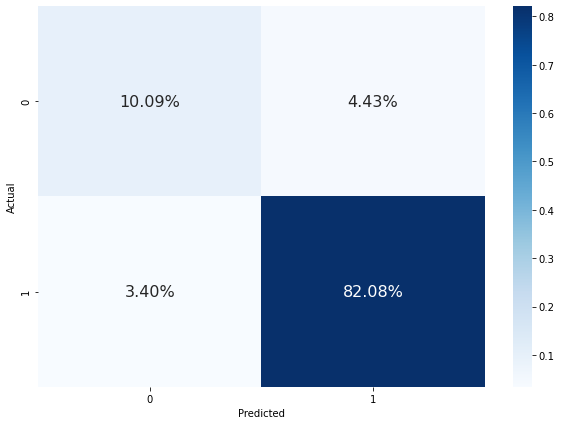

In [17]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, preds)
    df_cm = pd.DataFrame(cm/np.sum(cm), columns=np.unique(y_true), index=np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    # sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='.2%', annot_kws={"size": 16})
    #print("\nAccuracy: {}".format(accuracy_score(y_true, y_pred)))
    #print("Recall: {}".format(recall_score(y_true, y_pred)))
    #print("precision: {}".format(precision_score(y_true, y_pred)))
    #print("f1: {}".format(f1_score(y_true, y_pred)))
    print(classification_report(y_true, y_pred))

plot_confusion_matrix(test_dataset[1], preds)

              precision    recall  f1-score   support

           0       0.79      0.63      0.70       606
           1       0.94      0.97      0.95      3568

    accuracy                           0.92      4174
   macro avg       0.86      0.80      0.83      4174
weighted avg       0.92      0.92      0.92      4174



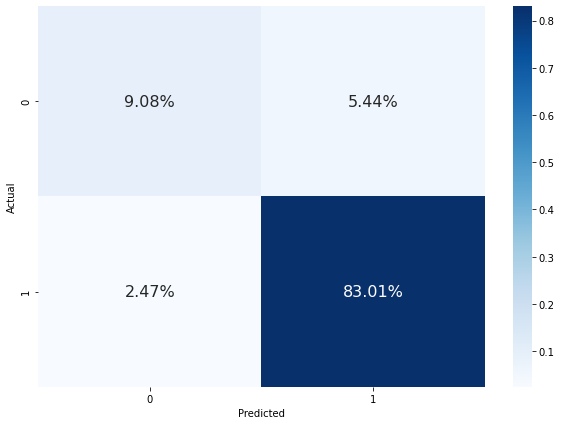

In [23]:
plot_confusion_matrix(test_dataset[1], preds)

In [21]:
# tqc.summary()
# for i, data in enumerate(train_dataset):
#     print(i)

def evaluate(predictions, true_labels, labels):
    records = []
    for threshold in np.linspace(0.1, 0.9, num=9):
        pred = [1 if p > threshold else 0 for p in predictions]
        acc = accuracy_score(true_labels, pred)
        rec_0 = recall_score(true_labels, pred, labels=[0,1])
        pre_0 = precision_score(true_labels, pred, labels=[0,1])
        f1_0 = f1_score(true_labels, pred, labels=[0,1])
        
        rec_1 = recall_score(true_labels, pred, labels=[1,0])
        pre_1 = precision_score(true_labels, pred, labels=[1,0])
        f1_1 = f1_score(true_labels, pred, labels=[1,0])
        roc_auc = roc_auc_score(true_labels, predictions)
        records.append((threshold, acc, rec_0, pre_0, f1_0, rec_1, pre_1, f1_1, roc_auc))

        df = pd.DataFrame(records, columns=["Threshold", "Accuracy", 
                                            "Recall_0", "Precision_0", "F1_0", 
                                            "Recall_1", "Precision_1", "F1_1",
                                            "Roc-Auc"])
    return df

evaluate(predictions, test_dataset[1], labels=[1,0])

,Threshold,Accuracy,Recall_0,Precision_0,F1_0,Recall_1,Precision_1,F1_1,Roc-Auc
0,0.1,0.920903,0.981559,0.929365,0.954749,0.981559,0.929365,0.954749,0.948422
1,0.2,0.920903,0.967868,0.940793,0.954139,0.967868,0.940793,0.954139,0.948422
2,0.3,0.918765,0.958648,0.946483,0.952526,0.958648,0.946483,0.952526,0.948422
3,0.4,0.914727,0.948310,0.951233,0.949769,0.948310,0.951233,0.949769,0.948422
4,0.5,0.912827,0.939648,0.957029,0.948259,0.939648,0.957029,0.948259,0.948422
5,0.6,0.911164,0.932383,0.961949,0.946935,0.932383,0.961949,0.946935,0.948422
6,0.7,0.905938,0.920648,0.967127,0.943315,0.920648,0.967127,0.943315,0.948422
7,0.8,0.892399,0.899693,0.971635,0.934281,0.899693,0.971635,0.934281,0.948422
8,0.9,0.867458,0.866443,0.974851,0.917456,0.866443,0.974851,0.917456,0.948422


In [17]:
"""Compute LaBSE output"""
import bert
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

def get_model(model_url, max_seq_length):
    
    labse_layer = hub.KerasLayer(model_url, trainable=False)

      # Define input.
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                             name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                     name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="segment_ids")

    # LaBSE layer.
    pooled_output,  _ = labse_layer([input_word_ids, input_mask, segment_ids])

    # The embedding is l2 normalized.
    pooled_output = tf.keras.layers.Lambda(
      lambda x: tf.nn.l2_normalize(x, axis=1))(pooled_output)

    # Define model.
    return tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids],
                          outputs=pooled_output), labse_layer

def create_input(input_strings, tokenizer, max_seq_length):

    input_ids_all, input_mask_all, segment_ids_all = [], [], []
    for input_string in input_strings:
        # Tokenize input.
        input_tokens = ["[CLS]"] + tokenizer.tokenize(input_string) + ["[SEP]"]
        input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
        sequence_length = min(len(input_ids), max_seq_length)

        # Padding or truncation.
        if len(input_ids) >= max_seq_length:
            input_ids = input_ids[:max_seq_length]
        else:
            input_ids = input_ids + [0] * (max_seq_length - len(input_ids))

        input_mask = [1] * sequence_length + [0] * (max_seq_length - sequence_length)

        input_ids_all.append(input_ids)
        input_mask_all.append(input_mask)
        segment_ids_all.append([0] * max_seq_length)

    return np.array(input_ids_all), np.array(input_mask_all), np.array(segment_ids_all)

def encode(input_text):
    input_ids, input_mask, segment_ids = create_input(
    input_text, tokenizer, max_seq_length)
    return labse_model([input_ids, input_mask, segment_ids])

def construct_model(max_seq_length=64):
    
    model_dir = "/linguistics/ethan/DL_Prototype/models/LaBSE_1"
    mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:5", "/gpu:6", "/gpu:7"])
    with mirrored_strategy.scope():
        labse_model, labse_layer = get_model(model_url=model_dir, 
                                             max_seq_length=max_seq_length)

    vocab_file = labse_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case = labse_layer.resolved_object.do_lower_case.numpy()
    tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)
    
    return labse_model, tokenizer

def compute_embeddings(input_texts, tokenizer, max_seq_length, labse_model):
    
    input_ids, input_mask, segment_ids = create_input(input_texts, tokenizer, max_seq_length)
    
    return labse_model([input_ids, input_mask, segment_ids])

In [18]:
max_seq_length=64
labse_model, tokenizer = construct_model(max_seq_length)
# model = hub.KerasLayer("", trainable=False)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [23]:
inputs = ["This is a test", "hello world", "give me a translation"] * 50
max_seq_length=64
embedding = compute_embeddings(inputs, tokenizer, max_seq_length, labse_model)

In [38]:
import pandas as pd
filepath = "/linguistics/ethan/DL_Prototype/datasets/TB_TQA/Unlabeled/Human_QA_finance_202102.tb_extracted.10k.xlsx"
df = pd.read_excel(filepath)
en_embedding_one = compute_embeddings(df["source"].to_numpy()[:2000], tokenizer, max_seq_length, labse_model)
fr_embedding_one = compute_embeddings(df["target"].to_numpy()[:2000], tokenizer, max_seq_length, labse_model)

en_embedding_two = compute_embeddings(df["source"].to_numpy()[2000:], tokenizer, max_seq_length, labse_model)
fr_embedding_two = compute_embeddings(df["target"].to_numpy()[2000:], tokenizer, max_seq_length, labse_model)

In [42]:
en_embedding = tf.concat([en_embedding_one, en_embedding_two], axis=0)
fr_embedding = tf.concat([fr_embedding_one, fr_embedding_two], axis=0)

In [44]:
print(en_embedding.shape)
print(fr_embedding.shape)
import pickle, json
filepath = "/linguistics/ethan/DL_Prototype/datasets/TB_TQA/Unlabeled/tb_extracted_20210526.5k.pkl"
data_dict = {"en_texts": df["source"].to_numpy(),
             "fr_texts": df["target"].to_numpy(),
             "en_embedding": en_embedding,
             "fr_embedding": fr_embedding}

with open(filepath, 'wb') as f:
    pickle.dump(data_dict, f)

(4932, 768)
(4932, 768)
